In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


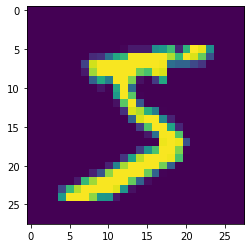

In [ ]:
%matplotlib inline 

plt.imshow(X_train[0])
plt.show()

In [ ]:
train_images = X_train/255
test_images = X_test/255

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:
def discriminator(int_shape = (28,28,1)):
  model = keras.Sequential([
                            keras.layers.Conv2D(8,(3,3),padding='same',input_shape=int_shape),
                            keras.layers.Flatten(),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Dense(200,activation='relu'),
                            keras.layers.Dense(60,activation='relu'),
                            keras.layers.Dense(1,activation='sigmoid')
  ])
  opt = Adam(learning_rate=0.0002,beta_1=0.2)
  model.compile(
      optimizer=opt,
      loss='binary_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [ ]:
model_D = discriminator()

In [ ]:
def generator(latent_dim=50):
  model = keras.Sequential([
                            keras.layers.Dense(7*7*256,input_dim=latent_dim),
                            keras.layers.LeakyReLU(alpha=0.3),
                            keras.layers.Reshape((7,7,256)),
                            keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'),
                            keras.layers.LeakyReLU(alpha=0.25),
                            keras.layers.Conv2D(1,(3,3),activation='relu',padding='same'),
  ])
  return model

In [ ]:
def GAN(model_D,model_G):
  model_D.trainable = False
  model = Sequential()
  model.add(model_G)
  model.add(model_D)
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
model_GAN = GAN(model_D,model_G)

In [ ]:
def generate_real_image(dataset,n_sample):
  i = np.random.randint(0,dataset.shape[0],n_sample)
  X = dataset[i]
  y = y = np.ones((n_sample, 1))
  return X,y

In [ ]:
model_G = generator()

In [ ]:
model_G.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             639744    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                            

In [ ]:
def generate_fake_image(latent_dim,n_sample,model_G):
  X_input = latent_point(latent_dim,n_sample)
  X = model_G.predict(X_input)
  X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
  y = np.zeros((n_sample, 1))
  return X,y

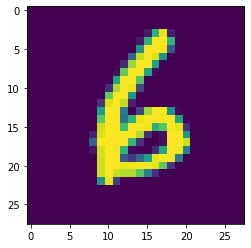

In [ ]:
X,y = generate_real_image(dataset,n_sample=5)
plt.imshow(X[0])

In [ ]:
Z = X.reshape(5,28,28,1)

In [ ]:
X,y = generate_fake_image(50,5,model_G)
X.shape

(5, 28, 28)

In [ ]:
def plot_images(images, n):
	# scales image values in the range of [0,1]
	images = (images-images.min())/(images.max() - images.min())
	for i in range(n):
		# define subplot
		plt.subplot(1, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i, :, :])
	plt.show()

In [ ]:
def latent_point(latent_dim,n_sample):
  X = np.random.randn(latent_dim*n_sample)
  X = X.reshape(n_sample,latent_dim)
  return X

In [ ]:
latent_dim = 50

In [ ]:
dataset = X_train

In [ ]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('/content/drive/MyDrive/GAN' +str(epoch)+ '.h5')
  X_real, y_real = generate_real_image(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_image(latent_dim, n_samples,model_G)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=50, n_batch=600):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_image(dataset, half_batch)
			X_fake, y_fake = generate_fake_image(latent_dim, half_batch,model_G)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = model_D.train_on_batch(X, y)
			X_gan = latent_point(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = model_GAN.train_on_batch(X_gan, y_gan)
			print('%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		

		X_temp,y_temp = generate_fake_image(latent_dim, 5,model_G)
		plot_images(X_temp,5)

		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, model_G, model_D, dataset, latent_dim)

1, 1/100, d=4.634, g=0.693
1, 2/100, d=0.402, g=0.694
1, 3/100, d=0.353, g=0.694
1, 4/100, d=0.360, g=0.694
1, 5/100, d=0.347, g=0.695
1, 6/100, d=0.347, g=0.695
1, 7/100, d=0.357, g=0.696
1, 8/100, d=0.347, g=0.696
1, 9/100, d=0.347, g=0.697
1, 10/100, d=0.346, g=0.698
1, 11/100, d=0.345, g=0.700
1, 12/100, d=0.345, g=0.701
1, 13/100, d=0.346, g=0.701
1, 14/100, d=0.360, g=0.703
1, 15/100, d=0.343, g=0.705
1, 16/100, d=0.342, g=0.709
1, 17/100, d=0.340, g=0.713
1, 18/100, d=0.339, g=0.718
1, 19/100, d=0.337, g=0.724
1, 20/100, d=0.334, g=0.731
1, 21/100, d=0.332, g=0.740
1, 22/100, d=0.328, g=0.748
1, 23/100, d=0.326, g=0.758
1, 24/100, d=0.320, g=0.769
1, 25/100, d=0.321, g=0.781
1, 26/100, d=0.312, g=0.790
1, 27/100, d=0.313, g=0.803
1, 28/100, d=0.322, g=0.816
1, 29/100, d=0.297, g=0.832
1, 30/100, d=0.292, g=0.848
1, 31/100, d=0.290, g=0.867
1, 32/100, d=0.300, g=0.881
1, 33/100, d=0.276, g=0.898
1, 34/100, d=0.270, g=0.919
1, 35/100, d=0.280, g=0.928
1, 36/100, d=0.259, g=0.951
1

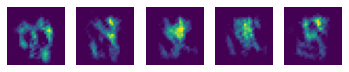

2, 1/100, d=0.486, g=0.062
2, 2/100, d=2.137, g=0.885
2, 3/100, d=0.589, g=3.509
2, 4/100, d=0.162, g=3.665
2, 5/100, d=0.083, g=3.008
2, 6/100, d=0.116, g=2.668
2, 7/100, d=0.083, g=3.321
2, 8/100, d=0.073, g=3.486
2, 9/100, d=0.047, g=3.056
2, 10/100, d=0.117, g=2.632
2, 11/100, d=0.089, g=3.140
2, 12/100, d=0.321, g=2.817
2, 13/100, d=0.125, g=2.669
2, 14/100, d=0.112, g=3.082
2, 15/100, d=0.110, g=1.746
2, 16/100, d=0.202, g=4.735
2, 17/100, d=0.044, g=3.067
2, 18/100, d=0.102, g=3.448
2, 19/100, d=0.052, g=3.937
2, 20/100, d=0.302, g=2.870
2, 21/100, d=0.082, g=3.448
2, 22/100, d=0.109, g=1.816
2, 23/100, d=0.240, g=5.069
2, 24/100, d=0.321, g=0.122
2, 25/100, d=1.867, g=4.920
2, 26/100, d=0.093, g=4.658
2, 27/100, d=0.022, g=4.261
2, 28/100, d=0.023, g=3.735
2, 29/100, d=0.038, g=3.527
2, 30/100, d=0.034, g=3.707
2, 31/100, d=0.039, g=3.833
2, 32/100, d=0.080, g=3.614
2, 33/100, d=0.037, g=3.706
2, 34/100, d=0.040, g=3.301
2, 35/100, d=0.051, g=3.096
2, 36/100, d=0.075, g=3.825
2

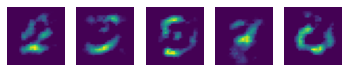

3, 1/100, d=0.340, g=3.340
3, 2/100, d=0.191, g=1.760
3, 3/100, d=0.281, g=3.486
3, 4/100, d=0.188, g=2.398
3, 5/100, d=0.154, g=3.913
3, 6/100, d=0.152, g=2.707
3, 7/100, d=0.166, g=4.134
3, 8/100, d=0.100, g=3.238
3, 9/100, d=0.070, g=3.511
3, 10/100, d=0.068, g=3.489
3, 11/100, d=0.088, g=4.076
3, 12/100, d=0.104, g=3.199
3, 13/100, d=0.079, g=3.645
3, 14/100, d=0.045, g=4.235
3, 15/100, d=0.088, g=2.891
3, 16/100, d=0.093, g=4.334
3, 17/100, d=0.052, g=3.900
3, 18/100, d=0.072, g=3.791
3, 19/100, d=0.055, g=4.076
3, 20/100, d=0.055, g=3.505
3, 21/100, d=0.080, g=3.916
3, 22/100, d=0.096, g=3.524
3, 23/100, d=0.083, g=3.558
3, 24/100, d=0.093, g=4.094
3, 25/100, d=0.101, g=3.574
3, 26/100, d=0.056, g=4.627
3, 27/100, d=0.125, g=1.108
3, 28/100, d=0.651, g=8.038
3, 29/100, d=1.297, g=0.041
3, 30/100, d=4.232, g=1.299
3, 31/100, d=0.781, g=3.408
3, 32/100, d=0.191, g=3.614
3, 33/100, d=0.157, g=3.313
3, 34/100, d=0.148, g=3.107
3, 35/100, d=0.121, g=3.250
3, 36/100, d=0.097, g=3.653
3

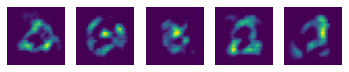

4, 1/100, d=0.114, g=3.477
4, 2/100, d=0.153, g=2.889
4, 3/100, d=0.097, g=3.474
4, 4/100, d=0.093, g=3.625
4, 5/100, d=0.150, g=2.437
4, 6/100, d=0.204, g=4.043
4, 7/100, d=0.124, g=1.993
4, 8/100, d=0.341, g=5.974
4, 9/100, d=0.528, g=0.376
4, 10/100, d=1.639, g=3.462
4, 11/100, d=0.064, g=3.992
4, 12/100, d=0.091, g=3.244
4, 13/100, d=0.057, g=3.180
4, 14/100, d=0.086, g=3.246
4, 15/100, d=0.090, g=3.058
4, 16/100, d=0.089, g=3.185
4, 17/100, d=0.086, g=2.984
4, 18/100, d=0.073, g=3.176
4, 19/100, d=0.107, g=2.959
4, 20/100, d=0.082, g=3.123
4, 21/100, d=0.113, g=3.189
4, 22/100, d=0.114, g=3.041
4, 23/100, d=0.087, g=3.326
4, 24/100, d=0.068, g=3.263
4, 25/100, d=0.088, g=2.943
4, 26/100, d=0.119, g=3.250
4, 27/100, d=0.065, g=3.398
4, 28/100, d=0.085, g=3.234
4, 29/100, d=0.066, g=3.431
4, 30/100, d=0.077, g=3.259
4, 31/100, d=0.106, g=3.428
4, 32/100, d=0.064, g=3.149
4, 33/100, d=0.111, g=3.391
4, 34/100, d=0.088, g=3.123
4, 35/100, d=0.077, g=3.578
4, 36/100, d=0.054, g=4.082
4

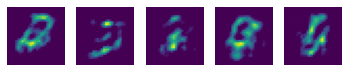

5, 1/100, d=0.062, g=3.603
5, 2/100, d=0.080, g=3.255
5, 3/100, d=0.090, g=3.425
5, 4/100, d=0.107, g=3.642
5, 5/100, d=0.091, g=3.450
5, 6/100, d=0.111, g=3.211
5, 7/100, d=0.134, g=3.098
5, 8/100, d=0.100, g=3.226
5, 9/100, d=0.080, g=3.294
5, 10/100, d=0.116, g=3.331
5, 11/100, d=0.102, g=3.385
5, 12/100, d=0.154, g=3.038
5, 13/100, d=0.106, g=3.380
5, 14/100, d=0.092, g=3.502
5, 15/100, d=0.087, g=3.652
5, 16/100, d=0.086, g=3.539
5, 17/100, d=0.091, g=3.273
5, 18/100, d=0.087, g=3.537
5, 19/100, d=0.072, g=3.492
5, 20/100, d=0.063, g=3.746
5, 21/100, d=0.105, g=3.496
5, 22/100, d=0.067, g=3.446
5, 23/100, d=0.085, g=3.677
5, 24/100, d=0.054, g=3.646
5, 25/100, d=0.083, g=3.689
5, 26/100, d=0.077, g=3.298
5, 27/100, d=0.066, g=3.669
5, 28/100, d=0.065, g=3.650
5, 29/100, d=0.081, g=3.335
5, 30/100, d=0.058, g=3.874
5, 31/100, d=0.054, g=4.098
5, 32/100, d=0.073, g=3.620
5, 33/100, d=0.048, g=3.525
5, 34/100, d=0.043, g=3.850
5, 35/100, d=0.057, g=3.960
5, 36/100, d=0.057, g=3.925
5

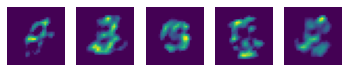

6, 1/100, d=0.067, g=5.193
6, 2/100, d=0.075, g=3.682
6, 3/100, d=0.130, g=4.974
6, 4/100, d=0.105, g=4.059
6, 5/100, d=0.109, g=5.356
6, 6/100, d=0.141, g=2.896
6, 7/100, d=0.296, g=8.407
6, 8/100, d=1.241, g=0.038
6, 9/100, d=6.596, g=4.610
6, 10/100, d=0.545, g=2.697
6, 11/100, d=0.307, g=3.574
6, 12/100, d=0.223, g=2.545
6, 13/100, d=0.190, g=3.335
6, 14/100, d=0.135, g=3.287
6, 15/100, d=0.137, g=3.131
6, 16/100, d=0.113, g=3.328
6, 17/100, d=0.111, g=3.385
6, 18/100, d=0.127, g=3.027
6, 19/100, d=0.160, g=2.991
6, 20/100, d=0.109, g=3.619
6, 21/100, d=0.114, g=3.583
6, 22/100, d=0.097, g=3.222
6, 23/100, d=0.141, g=3.466
6, 24/100, d=0.118, g=3.323
6, 25/100, d=0.113, g=3.551
6, 26/100, d=0.099, g=3.800
6, 27/100, d=0.090, g=3.680
6, 28/100, d=0.102, g=3.473
6, 29/100, d=0.099, g=3.676
6, 30/100, d=0.137, g=3.470
6, 31/100, d=0.107, g=3.718
6, 32/100, d=0.071, g=3.706
6, 33/100, d=0.100, g=3.642
6, 34/100, d=0.078, g=3.676
6, 35/100, d=0.094, g=3.516
6, 36/100, d=0.105, g=3.826
6

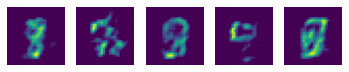

7, 1/100, d=1.316, g=8.459
7, 2/100, d=1.190, g=0.732
7, 3/100, d=1.462, g=5.531
7, 4/100, d=0.102, g=5.591
7, 5/100, d=0.184, g=4.271
7, 6/100, d=0.134, g=4.392
7, 7/100, d=0.103, g=4.494
7, 8/100, d=0.136, g=4.541
7, 9/100, d=0.134, g=4.228
7, 10/100, d=0.146, g=3.918
7, 11/100, d=0.171, g=4.800
7, 12/100, d=0.171, g=3.826
7, 13/100, d=0.131, g=4.568
7, 14/100, d=0.115, g=4.736
7, 15/100, d=0.109, g=4.659
7, 16/100, d=0.084, g=4.445
7, 17/100, d=0.090, g=5.058
7, 18/100, d=0.096, g=4.379
7, 19/100, d=0.140, g=4.370
7, 20/100, d=0.087, g=4.721
7, 21/100, d=0.089, g=4.778
7, 22/100, d=0.086, g=4.651
7, 23/100, d=0.108, g=4.055
7, 24/100, d=0.094, g=4.594
7, 25/100, d=0.171, g=4.248
7, 26/100, d=0.080, g=4.250
7, 27/100, d=0.083, g=4.082
7, 28/100, d=0.125, g=4.415
7, 29/100, d=0.097, g=4.476
7, 30/100, d=0.089, g=4.318
7, 31/100, d=0.137, g=4.423
7, 32/100, d=0.051, g=4.607
7, 33/100, d=0.076, g=4.697
7, 34/100, d=0.057, g=4.786
7, 35/100, d=0.056, g=4.557
7, 36/100, d=0.082, g=4.597
7

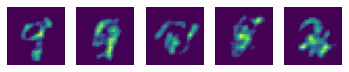

8, 1/100, d=0.087, g=4.907
8, 2/100, d=0.057, g=4.931
8, 3/100, d=0.054, g=5.041
8, 4/100, d=0.070, g=4.481
8, 5/100, d=0.088, g=5.976
8, 6/100, d=0.139, g=3.874
8, 7/100, d=0.070, g=4.927
8, 8/100, d=0.100, g=4.341
8, 9/100, d=0.095, g=6.026
8, 10/100, d=0.152, g=3.692
8, 11/100, d=0.161, g=6.658
8, 12/100, d=0.192, g=3.033
8, 13/100, d=0.265, g=6.840
8, 14/100, d=0.288, g=3.034
8, 15/100, d=0.198, g=5.876
8, 16/100, d=0.104, g=4.801
8, 17/100, d=0.077, g=4.317
8, 18/100, d=0.120, g=5.003
8, 19/100, d=0.086, g=4.640
8, 20/100, d=0.101, g=4.771
8, 21/100, d=0.095, g=5.351
8, 22/100, d=0.095, g=4.705
8, 23/100, d=0.103, g=5.082
8, 24/100, d=0.094, g=4.005
8, 25/100, d=0.083, g=5.627
8, 26/100, d=0.084, g=5.429
8, 27/100, d=0.066, g=4.916
8, 28/100, d=0.101, g=5.553
8, 29/100, d=0.077, g=5.027
8, 30/100, d=0.084, g=4.952
8, 31/100, d=0.082, g=5.707
8, 32/100, d=0.084, g=4.744
8, 33/100, d=0.071, g=5.051
8, 34/100, d=0.098, g=5.855
8, 35/100, d=0.096, g=4.694
8, 36/100, d=0.135, g=6.015
8

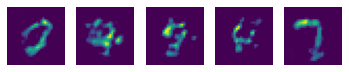

9, 1/100, d=0.070, g=5.267
9, 2/100, d=0.076, g=4.056
9, 3/100, d=0.118, g=5.511
9, 4/100, d=0.125, g=4.980
9, 5/100, d=0.073, g=5.102
9, 6/100, d=0.094, g=4.819
9, 7/100, d=0.076, g=4.529
9, 8/100, d=0.091, g=5.356
9, 9/100, d=0.106, g=4.143
9, 10/100, d=0.089, g=5.332
9, 11/100, d=0.070, g=4.541
9, 12/100, d=0.122, g=6.085
9, 13/100, d=0.160, g=4.109
9, 14/100, d=0.144, g=5.254
9, 15/100, d=0.075, g=4.769
9, 16/100, d=0.079, g=4.682
9, 17/100, d=0.092, g=4.876
9, 18/100, d=0.068, g=4.957
9, 19/100, d=0.057, g=4.757
9, 20/100, d=0.078, g=4.586
9, 21/100, d=0.078, g=5.104
9, 22/100, d=0.118, g=4.326
9, 23/100, d=0.096, g=5.094
9, 24/100, d=0.086, g=4.490
9, 25/100, d=0.088, g=5.019
9, 26/100, d=0.068, g=5.114
9, 27/100, d=0.083, g=4.505
9, 28/100, d=0.078, g=4.897
9, 29/100, d=0.059, g=5.044
9, 30/100, d=0.084, g=5.068
9, 31/100, d=0.072, g=4.349
9, 32/100, d=0.096, g=5.485
9, 33/100, d=0.084, g=4.422
9, 34/100, d=0.084, g=4.971
9, 35/100, d=0.088, g=4.042
9, 36/100, d=0.095, g=5.834
9

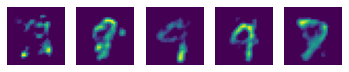

10, 1/100, d=0.062, g=5.126
10, 2/100, d=0.120, g=5.143
10, 3/100, d=0.089, g=4.784
10, 4/100, d=0.096, g=4.559
10, 5/100, d=0.097, g=5.619
10, 6/100, d=0.068, g=4.926
10, 7/100, d=0.088, g=5.031
10, 8/100, d=0.082, g=4.870
10, 9/100, d=0.057, g=5.019
10, 10/100, d=0.083, g=4.751
10, 11/100, d=0.075, g=5.541
10, 12/100, d=0.062, g=4.073
10, 13/100, d=0.118, g=6.243
10, 14/100, d=0.120, g=4.405
10, 15/100, d=0.102, g=5.690
10, 16/100, d=0.102, g=3.917
10, 17/100, d=0.085, g=5.554
10, 18/100, d=0.078, g=4.471
10, 19/100, d=0.068, g=5.121
10, 20/100, d=0.073, g=5.265
10, 21/100, d=0.085, g=4.404
10, 22/100, d=0.110, g=5.105
10, 23/100, d=0.072, g=5.158
10, 24/100, d=0.127, g=4.031
10, 25/100, d=0.109, g=6.420
10, 26/100, d=0.226, g=2.725
10, 27/100, d=0.323, g=8.471
10, 28/100, d=0.626, g=2.583
10, 29/100, d=0.292, g=5.892
10, 30/100, d=0.209, g=4.101
10, 31/100, d=0.089, g=4.260
10, 32/100, d=0.088, g=4.827
10, 33/100, d=0.094, g=4.407
10, 34/100, d=0.092, g=5.136
10, 35/100, d=0.108, g=

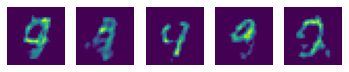

Accuracy real: 99%, fake: 97%
11, 1/100, d=0.055, g=4.558
11, 2/100, d=0.071, g=5.059
11, 3/100, d=0.076, g=4.481
11, 4/100, d=0.072, g=5.107
11, 5/100, d=0.083, g=4.254
11, 6/100, d=0.087, g=6.010
11, 7/100, d=0.073, g=4.779
11, 8/100, d=0.050, g=4.744
11, 9/100, d=0.061, g=5.408
11, 10/100, d=0.091, g=4.526
11, 11/100, d=0.078, g=5.111
11, 12/100, d=0.078, g=4.293
11, 13/100, d=0.095, g=6.217
11, 14/100, d=0.084, g=4.318
11, 15/100, d=0.077, g=4.885
11, 16/100, d=0.058, g=5.085
11, 17/100, d=0.095, g=4.280
11, 18/100, d=0.105, g=6.346
11, 19/100, d=0.067, g=4.153
11, 20/100, d=0.088, g=5.451
11, 21/100, d=0.073, g=4.750
11, 22/100, d=0.071, g=5.746
11, 23/100, d=0.063, g=4.616
11, 24/100, d=0.083, g=5.294
11, 25/100, d=0.058, g=4.817
11, 26/100, d=0.066, g=4.956
11, 27/100, d=0.069, g=4.969
11, 28/100, d=0.060, g=5.122
11, 29/100, d=0.054, g=4.745
11, 30/100, d=0.091, g=3.966
11, 31/100, d=0.100, g=6.177
11, 32/100, d=0.096, g=4.739
11, 33/100, d=0.065, g=4.924
11, 34/100, d=0.064, g

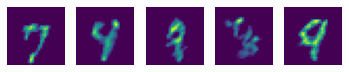

12, 1/100, d=0.129, g=6.179
12, 2/100, d=0.099, g=4.335
12, 3/100, d=0.100, g=4.530
12, 4/100, d=0.107, g=5.560
12, 5/100, d=0.107, g=3.623
12, 6/100, d=0.118, g=6.359
12, 7/100, d=0.104, g=4.067
12, 8/100, d=0.095, g=5.516
12, 9/100, d=0.112, g=4.114
12, 10/100, d=0.093, g=5.153
12, 11/100, d=0.074, g=4.484
12, 12/100, d=0.052, g=4.198
12, 13/100, d=0.108, g=4.996
12, 14/100, d=0.112, g=3.548
12, 15/100, d=0.133, g=7.521
12, 16/100, d=0.257, g=3.799
12, 17/100, d=0.101, g=5.469
12, 18/100, d=0.102, g=4.342
12, 19/100, d=0.088, g=4.585
12, 20/100, d=0.093, g=5.247
12, 21/100, d=0.055, g=5.008
12, 22/100, d=0.107, g=3.236
12, 23/100, d=0.123, g=7.044
12, 24/100, d=0.194, g=3.461
12, 25/100, d=0.227, g=6.766
12, 26/100, d=0.228, g=3.231
12, 27/100, d=0.176, g=6.032
12, 28/100, d=0.160, g=4.032
12, 29/100, d=0.085, g=5.331
12, 30/100, d=0.104, g=4.279
12, 31/100, d=0.086, g=4.719
12, 32/100, d=0.058, g=5.010
12, 33/100, d=0.074, g=4.266
12, 34/100, d=0.074, g=4.456
12, 35/100, d=0.098, g=

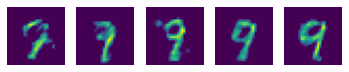

13, 1/100, d=0.063, g=4.471
13, 2/100, d=0.086, g=4.929
13, 3/100, d=0.065, g=4.998
13, 4/100, d=0.065, g=4.397
13, 5/100, d=0.053, g=4.452
13, 6/100, d=0.074, g=5.312
13, 7/100, d=0.083, g=3.852
13, 8/100, d=0.098, g=6.247
13, 9/100, d=0.072, g=4.888
13, 10/100, d=0.093, g=4.848
13, 11/100, d=0.058, g=4.810
13, 12/100, d=0.056, g=5.079
13, 13/100, d=0.091, g=5.162
13, 14/100, d=0.084, g=4.515
13, 15/100, d=0.093, g=5.256
13, 16/100, d=0.094, g=4.549
13, 17/100, d=0.102, g=5.138
13, 18/100, d=0.081, g=3.878
13, 19/100, d=0.098, g=6.446
13, 20/100, d=0.084, g=4.384
13, 21/100, d=0.084, g=4.990
13, 22/100, d=0.098, g=4.729
13, 23/100, d=0.051, g=5.155
13, 24/100, d=0.049, g=5.370
13, 25/100, d=0.085, g=4.522
13, 26/100, d=0.070, g=6.466
13, 27/100, d=0.093, g=3.687
13, 28/100, d=0.140, g=6.982
13, 29/100, d=0.166, g=3.833
13, 30/100, d=0.129, g=6.201
13, 31/100, d=0.162, g=3.093
13, 32/100, d=0.158, g=7.371
13, 33/100, d=0.198, g=4.783
13, 34/100, d=0.121, g=4.346
13, 35/100, d=0.152, g=

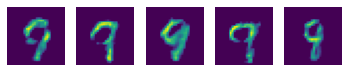

14, 1/100, d=0.061, g=4.660
14, 2/100, d=0.074, g=3.827
14, 3/100, d=0.121, g=5.814
14, 4/100, d=0.104, g=4.076
14, 5/100, d=0.076, g=5.269
14, 6/100, d=0.123, g=3.587
14, 7/100, d=0.071, g=5.544
14, 8/100, d=0.084, g=4.091
14, 9/100, d=0.071, g=5.304
14, 10/100, d=0.091, g=3.994
14, 11/100, d=0.127, g=4.687
14, 12/100, d=0.104, g=4.555
14, 13/100, d=0.054, g=4.474
14, 14/100, d=0.098, g=4.636
14, 15/100, d=0.054, g=4.966
14, 16/100, d=0.103, g=3.366
14, 17/100, d=0.139, g=7.082
14, 18/100, d=0.200, g=4.175
14, 19/100, d=0.091, g=4.930
14, 20/100, d=0.088, g=4.532
14, 21/100, d=0.069, g=4.860
14, 22/100, d=0.108, g=3.826
14, 23/100, d=0.104, g=5.199
14, 24/100, d=0.125, g=3.306
14, 25/100, d=0.146, g=6.341
14, 26/100, d=0.145, g=3.660
14, 27/100, d=0.130, g=5.799
14, 28/100, d=0.115, g=4.723
14, 29/100, d=0.098, g=4.028
14, 30/100, d=0.107, g=5.408
14, 31/100, d=0.105, g=4.318
14, 32/100, d=0.092, g=5.137
14, 33/100, d=0.089, g=4.205
14, 34/100, d=0.086, g=5.183
14, 35/100, d=0.115, g=

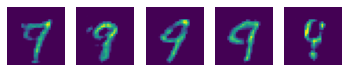

15, 1/100, d=0.067, g=4.002
15, 2/100, d=0.080, g=5.338
15, 3/100, d=0.081, g=3.828
15, 4/100, d=0.096, g=5.337
15, 5/100, d=0.096, g=5.105
15, 6/100, d=0.076, g=4.385
15, 7/100, d=0.084, g=4.714
15, 8/100, d=0.132, g=3.453
15, 9/100, d=0.093, g=5.126
15, 10/100, d=0.095, g=3.811
15, 11/100, d=0.084, g=5.822
15, 12/100, d=0.095, g=4.084
15, 13/100, d=0.095, g=4.582
15, 14/100, d=0.102, g=3.738
15, 15/100, d=0.100, g=5.639
15, 16/100, d=0.073, g=4.730
15, 17/100, d=0.090, g=4.884
15, 18/100, d=0.051, g=4.482
15, 19/100, d=0.087, g=4.309
15, 20/100, d=0.100, g=5.691
15, 21/100, d=0.151, g=2.572
15, 22/100, d=0.220, g=8.385
15, 23/100, d=0.368, g=4.858
15, 24/100, d=0.114, g=3.842
15, 25/100, d=0.097, g=4.309
15, 26/100, d=0.107, g=3.686
15, 27/100, d=0.111, g=4.774
15, 28/100, d=0.104, g=3.888
15, 29/100, d=0.099, g=4.489
15, 30/100, d=0.085, g=4.105
15, 31/100, d=0.083, g=3.486
15, 32/100, d=0.113, g=5.450
15, 33/100, d=0.127, g=3.369
15, 34/100, d=0.106, g=5.192
15, 35/100, d=0.094, g=

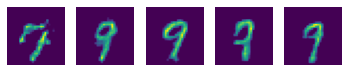

16, 1/100, d=0.101, g=3.510
16, 2/100, d=0.130, g=5.993
16, 3/100, d=0.165, g=3.498
16, 4/100, d=0.140, g=5.625
16, 5/100, d=0.124, g=4.058
16, 6/100, d=0.087, g=4.479
16, 7/100, d=0.113, g=4.879
16, 8/100, d=0.112, g=4.037
16, 9/100, d=0.093, g=3.950
16, 10/100, d=0.083, g=5.216
16, 11/100, d=0.153, g=3.096
16, 12/100, d=0.143, g=6.726
16, 13/100, d=0.189, g=4.194
16, 14/100, d=0.076, g=4.835
16, 15/100, d=0.128, g=4.039
16, 16/100, d=0.129, g=4.035
16, 17/100, d=0.080, g=4.901
16, 18/100, d=0.078, g=4.554
16, 19/100, d=0.097, g=4.036
16, 20/100, d=0.078, g=4.995
16, 21/100, d=0.135, g=4.017
16, 22/100, d=0.085, g=5.942
16, 23/100, d=0.149, g=3.968
16, 24/100, d=0.102, g=4.017
16, 25/100, d=0.094, g=4.532
16, 26/100, d=0.075, g=5.033
16, 27/100, d=0.110, g=3.879
16, 28/100, d=0.117, g=4.525
16, 29/100, d=0.094, g=4.903
16, 30/100, d=0.102, g=4.133
16, 31/100, d=0.100, g=5.458
16, 32/100, d=0.113, g=4.015
16, 33/100, d=0.079, g=5.454
16, 34/100, d=0.125, g=3.239
16, 35/100, d=0.149, g=

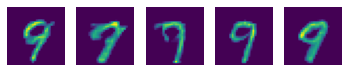

17, 1/100, d=0.143, g=6.856
17, 2/100, d=0.223, g=3.826
17, 3/100, d=0.125, g=4.912
17, 4/100, d=0.080, g=4.600
17, 5/100, d=0.106, g=4.121
17, 6/100, d=0.091, g=3.835
17, 7/100, d=0.138, g=5.137
17, 8/100, d=0.106, g=4.351
17, 9/100, d=0.128, g=4.291
17, 10/100, d=0.089, g=5.109
17, 11/100, d=0.148, g=3.497
17, 12/100, d=0.110, g=5.839
17, 13/100, d=0.092, g=4.512
17, 14/100, d=0.065, g=3.863
17, 15/100, d=0.084, g=4.938
17, 16/100, d=0.090, g=4.540
17, 17/100, d=0.072, g=4.076
17, 18/100, d=0.102, g=5.237
17, 19/100, d=0.096, g=4.434
17, 20/100, d=0.150, g=4.557
17, 21/100, d=0.103, g=4.498
17, 22/100, d=0.086, g=4.651
17, 23/100, d=0.074, g=4.982
17, 24/100, d=0.101, g=3.645
17, 25/100, d=0.129, g=5.225
17, 26/100, d=0.092, g=4.792
17, 27/100, d=0.078, g=4.228
17, 28/100, d=0.106, g=5.092
17, 29/100, d=0.065, g=4.385
17, 30/100, d=0.112, g=5.679
17, 31/100, d=0.109, g=4.448
17, 32/100, d=0.072, g=5.257
17, 33/100, d=0.122, g=3.805
17, 34/100, d=0.133, g=4.490
17, 35/100, d=0.089, g=

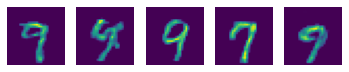

18, 1/100, d=0.109, g=4.108
18, 2/100, d=0.094, g=3.931
18, 3/100, d=0.078, g=3.881
18, 4/100, d=0.099, g=4.673
18, 5/100, d=0.107, g=3.220
18, 6/100, d=0.145, g=5.410
18, 7/100, d=0.088, g=4.527
18, 8/100, d=0.085, g=3.566
18, 9/100, d=0.114, g=5.580
18, 10/100, d=0.148, g=3.185
18, 11/100, d=0.126, g=6.426
18, 12/100, d=0.170, g=4.769
18, 13/100, d=0.136, g=3.669
18, 14/100, d=0.128, g=4.704
18, 15/100, d=0.131, g=3.939
18, 16/100, d=0.107, g=3.526
18, 17/100, d=0.137, g=6.617
18, 18/100, d=0.226, g=3.885
18, 19/100, d=0.072, g=3.752
18, 20/100, d=0.100, g=4.214
18, 21/100, d=0.113, g=4.794
18, 22/100, d=0.085, g=4.211
18, 23/100, d=0.088, g=4.356
18, 24/100, d=0.085, g=3.951
18, 25/100, d=0.114, g=4.677
18, 26/100, d=0.085, g=4.551
18, 27/100, d=0.102, g=4.364
18, 28/100, d=0.091, g=3.993
18, 29/100, d=0.105, g=4.466
18, 30/100, d=0.104, g=3.648
18, 31/100, d=0.113, g=5.037
18, 32/100, d=0.090, g=3.754
18, 33/100, d=0.124, g=5.322
18, 34/100, d=0.164, g=3.090
18, 35/100, d=0.180, g=

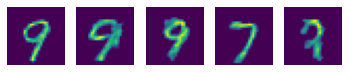

19, 1/100, d=0.092, g=4.955
19, 2/100, d=0.097, g=4.557
19, 3/100, d=0.131, g=3.830
19, 4/100, d=0.140, g=4.269
19, 5/100, d=0.091, g=3.760
19, 6/100, d=0.100, g=5.572
19, 7/100, d=0.090, g=4.671
19, 8/100, d=0.113, g=3.522
19, 9/100, d=0.106, g=5.379
19, 10/100, d=0.153, g=3.228
19, 11/100, d=0.120, g=5.163
19, 12/100, d=0.116, g=3.867
19, 13/100, d=0.088, g=5.399
19, 14/100, d=0.120, g=4.011
19, 15/100, d=0.077, g=4.716
19, 16/100, d=0.101, g=4.960
19, 17/100, d=0.099, g=4.169
19, 18/100, d=0.108, g=5.477
19, 19/100, d=0.153, g=3.349
19, 20/100, d=0.171, g=6.260
19, 21/100, d=0.209, g=3.697
19, 22/100, d=0.103, g=5.638
19, 23/100, d=0.147, g=3.907
19, 24/100, d=0.121, g=4.318
19, 25/100, d=0.090, g=4.063
19, 26/100, d=0.103, g=3.786
19, 27/100, d=0.116, g=4.453
19, 28/100, d=0.113, g=3.856
19, 29/100, d=0.066, g=4.355
19, 30/100, d=0.119, g=3.951
19, 31/100, d=0.105, g=4.060
19, 32/100, d=0.094, g=4.879
19, 33/100, d=0.122, g=3.844
19, 34/100, d=0.112, g=4.912
19, 35/100, d=0.079, g=

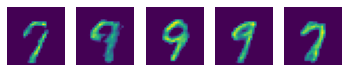

20, 1/100, d=0.088, g=4.833
20, 2/100, d=0.118, g=3.429
20, 3/100, d=0.113, g=6.314
20, 4/100, d=0.164, g=3.768
20, 5/100, d=0.160, g=5.403
20, 6/100, d=0.141, g=3.907
20, 7/100, d=0.148, g=3.335
20, 8/100, d=0.126, g=5.571
20, 9/100, d=0.164, g=3.143
20, 10/100, d=0.148, g=5.961
20, 11/100, d=0.152, g=4.366
20, 12/100, d=0.108, g=4.350
20, 13/100, d=0.133, g=3.901
20, 14/100, d=0.124, g=4.622
20, 15/100, d=0.109, g=3.350
20, 16/100, d=0.137, g=5.078
20, 17/100, d=0.112, g=4.173
20, 18/100, d=0.133, g=4.047
20, 19/100, d=0.125, g=3.894
20, 20/100, d=0.101, g=4.295
20, 21/100, d=0.122, g=3.738
20, 22/100, d=0.103, g=4.568
20, 23/100, d=0.139, g=3.594
20, 24/100, d=0.127, g=5.609
20, 25/100, d=0.175, g=3.766
20, 26/100, d=0.094, g=4.688
20, 27/100, d=0.111, g=4.129
20, 28/100, d=0.104, g=4.101
20, 29/100, d=0.117, g=3.105
20, 30/100, d=0.154, g=6.168
20, 31/100, d=0.184, g=4.060
20, 32/100, d=0.140, g=4.036
20, 33/100, d=0.108, g=4.588
20, 34/100, d=0.138, g=4.003
20, 35/100, d=0.147, g=

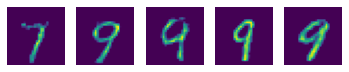

Accuracy real: 94%, fake: 96%
21, 1/100, d=0.139, g=3.807
21, 2/100, d=0.087, g=4.859
21, 3/100, d=0.088, g=4.723
21, 4/100, d=0.098, g=3.758
21, 5/100, d=0.141, g=4.564
21, 6/100, d=0.112, g=4.056
21, 7/100, d=0.105, g=3.719
21, 8/100, d=0.099, g=4.355
21, 9/100, d=0.113, g=4.337
21, 10/100, d=0.107, g=3.810
21, 11/100, d=0.099, g=4.427
21, 12/100, d=0.145, g=3.289
21, 13/100, d=0.131, g=4.566
21, 14/100, d=0.124, g=3.512
21, 15/100, d=0.085, g=4.300
21, 16/100, d=0.111, g=3.803
21, 17/100, d=0.112, g=4.774
21, 18/100, d=0.109, g=3.626
21, 19/100, d=0.110, g=3.836
21, 20/100, d=0.087, g=4.812
21, 21/100, d=0.099, g=3.934
21, 22/100, d=0.109, g=4.420
21, 23/100, d=0.079, g=4.164
21, 24/100, d=0.105, g=3.686
21, 25/100, d=0.135, g=4.766
21, 26/100, d=0.146, g=3.314
21, 27/100, d=0.108, g=5.411
21, 28/100, d=0.165, g=3.480
21, 29/100, d=0.118, g=4.752
21, 30/100, d=0.133, g=3.151
21, 31/100, d=0.131, g=5.156
21, 32/100, d=0.135, g=3.892
21, 33/100, d=0.078, g=4.089
21, 34/100, d=0.093, g

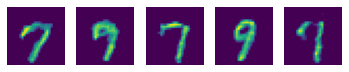

22, 1/100, d=0.108, g=4.384
22, 2/100, d=0.102, g=4.605
22, 3/100, d=0.134, g=3.851
22, 4/100, d=0.107, g=4.894
22, 5/100, d=0.129, g=3.773
22, 6/100, d=0.114, g=4.637
22, 7/100, d=0.094, g=4.075
22, 8/100, d=0.130, g=4.388
22, 9/100, d=0.167, g=3.323
22, 10/100, d=0.148, g=5.018
22, 11/100, d=0.130, g=3.318
22, 12/100, d=0.116, g=4.496
22, 13/100, d=0.103, g=3.941
22, 14/100, d=0.103, g=4.095
22, 15/100, d=0.131, g=3.900
22, 16/100, d=0.106, g=4.670
22, 17/100, d=0.130, g=3.508
22, 18/100, d=0.131, g=4.194
22, 19/100, d=0.101, g=3.652
22, 20/100, d=0.094, g=4.857
22, 21/100, d=0.161, g=3.536
22, 22/100, d=0.120, g=4.192
22, 23/100, d=0.096, g=4.275
22, 24/100, d=0.124, g=3.758
22, 25/100, d=0.101, g=4.779
22, 26/100, d=0.090, g=3.965
22, 27/100, d=0.134, g=4.220
22, 28/100, d=0.134, g=3.203
22, 29/100, d=0.140, g=5.162
22, 30/100, d=0.110, g=4.190
22, 31/100, d=0.121, g=3.743
22, 32/100, d=0.117, g=4.979
22, 33/100, d=0.087, g=3.727
22, 34/100, d=0.126, g=4.149
22, 35/100, d=0.113, g=

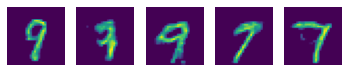

23, 1/100, d=0.138, g=3.964
23, 2/100, d=0.141, g=3.646
23, 3/100, d=0.137, g=5.286
23, 4/100, d=0.147, g=3.637
23, 5/100, d=0.125, g=4.252
23, 6/100, d=0.119, g=3.602
23, 7/100, d=0.124, g=4.846
23, 8/100, d=0.142, g=3.179
23, 9/100, d=0.181, g=5.524
23, 10/100, d=0.149, g=3.237
23, 11/100, d=0.119, g=4.888
23, 12/100, d=0.164, g=3.662
23, 13/100, d=0.117, g=3.456
23, 14/100, d=0.130, g=5.184
23, 15/100, d=0.145, g=3.624
23, 16/100, d=0.105, g=3.371
23, 17/100, d=0.137, g=4.140
23, 18/100, d=0.116, g=3.342
23, 19/100, d=0.160, g=5.681
23, 20/100, d=0.145, g=4.134
23, 21/100, d=0.133, g=4.054
23, 22/100, d=0.136, g=3.377
23, 23/100, d=0.121, g=4.055
23, 24/100, d=0.100, g=4.037
23, 25/100, d=0.107, g=4.510
23, 26/100, d=0.086, g=4.399
23, 27/100, d=0.089, g=3.758
23, 28/100, d=0.099, g=4.085
23, 29/100, d=0.098, g=4.642
23, 30/100, d=0.107, g=3.939
23, 31/100, d=0.116, g=3.913
23, 32/100, d=0.087, g=4.411
23, 33/100, d=0.134, g=3.534
23, 34/100, d=0.104, g=3.876
23, 35/100, d=0.123, g=

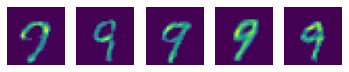

24, 1/100, d=0.114, g=3.891
24, 2/100, d=0.078, g=4.116
24, 3/100, d=0.114, g=4.243
24, 4/100, d=0.089, g=3.913
24, 5/100, d=0.096, g=3.823
24, 6/100, d=0.130, g=4.101
24, 7/100, d=0.099, g=4.331
24, 8/100, d=0.093, g=4.412
24, 9/100, d=0.122, g=2.978
24, 10/100, d=0.149, g=6.046
24, 11/100, d=0.219, g=4.133
24, 12/100, d=0.097, g=3.835
24, 13/100, d=0.121, g=3.800
24, 14/100, d=0.128, g=3.844
24, 15/100, d=0.076, g=4.538
24, 16/100, d=0.099, g=4.276
24, 17/100, d=0.148, g=3.140
24, 18/100, d=0.121, g=5.063
24, 19/100, d=0.118, g=4.032
24, 20/100, d=0.136, g=3.821
24, 21/100, d=0.085, g=3.932
24, 22/100, d=0.112, g=4.134
24, 23/100, d=0.090, g=3.447
24, 24/100, d=0.115, g=5.257
24, 25/100, d=0.169, g=4.004
24, 26/100, d=0.120, g=3.686
24, 27/100, d=0.111, g=4.590
24, 28/100, d=0.128, g=3.864
24, 29/100, d=0.091, g=3.520
24, 30/100, d=0.078, g=4.253
24, 31/100, d=0.102, g=3.700
24, 32/100, d=0.119, g=4.322
24, 33/100, d=0.086, g=4.072
24, 34/100, d=0.097, g=4.047
24, 35/100, d=0.129, g=

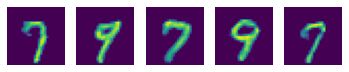

25, 1/100, d=0.086, g=3.860
25, 2/100, d=0.105, g=4.678
25, 3/100, d=0.118, g=4.089
25, 4/100, d=0.136, g=3.694
25, 5/100, d=0.125, g=4.336
25, 6/100, d=0.110, g=3.891
25, 7/100, d=0.112, g=4.381
25, 8/100, d=0.126, g=3.694
25, 9/100, d=0.115, g=4.565
25, 10/100, d=0.142, g=2.862
25, 11/100, d=0.190, g=6.082
25, 12/100, d=0.188, g=4.374
25, 13/100, d=0.138, g=3.238
25, 14/100, d=0.104, g=4.856
25, 15/100, d=0.099, g=4.127
25, 16/100, d=0.152, g=3.600
25, 17/100, d=0.121, g=3.979
25, 18/100, d=0.115, g=4.137
25, 19/100, d=0.083, g=3.722
25, 20/100, d=0.114, g=4.622
25, 21/100, d=0.113, g=3.641
25, 22/100, d=0.086, g=3.965
25, 23/100, d=0.102, g=4.193
25, 24/100, d=0.111, g=4.074
25, 25/100, d=0.103, g=3.647
25, 26/100, d=0.097, g=4.226
25, 27/100, d=0.131, g=3.901
25, 28/100, d=0.109, g=4.115
25, 29/100, d=0.120, g=4.929
25, 30/100, d=0.165, g=3.012
25, 31/100, d=0.147, g=5.655
25, 32/100, d=0.106, g=4.655
25, 33/100, d=0.087, g=3.785
25, 34/100, d=0.103, g=4.146
25, 35/100, d=0.090, g=

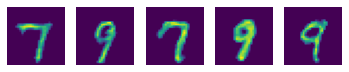

26, 1/100, d=0.128, g=3.414
26, 2/100, d=0.121, g=5.222
26, 3/100, d=0.211, g=3.369
26, 4/100, d=0.134, g=4.931
26, 5/100, d=0.105, g=4.029
26, 6/100, d=0.131, g=3.856
26, 7/100, d=0.101, g=4.626
26, 8/100, d=0.161, g=3.375
26, 9/100, d=0.119, g=4.243
26, 10/100, d=0.113, g=3.837
26, 11/100, d=0.106, g=3.494
26, 12/100, d=0.133, g=4.979
26, 13/100, d=0.124, g=3.749
26, 14/100, d=0.103, g=3.866
26, 15/100, d=0.119, g=3.965
26, 16/100, d=0.072, g=4.233
26, 17/100, d=0.106, g=3.953
26, 18/100, d=0.096, g=3.877
26, 19/100, d=0.115, g=4.613
26, 20/100, d=0.126, g=3.798
26, 21/100, d=0.096, g=4.546
26, 22/100, d=0.115, g=4.231
26, 23/100, d=0.097, g=4.335
26, 24/100, d=0.096, g=4.428
26, 25/100, d=0.123, g=3.810
26, 26/100, d=0.121, g=3.591
26, 27/100, d=0.111, g=4.510
26, 28/100, d=0.117, g=3.659
26, 29/100, d=0.103, g=4.996
26, 30/100, d=0.137, g=3.669
26, 31/100, d=0.142, g=4.388
26, 32/100, d=0.091, g=4.811
26, 33/100, d=0.149, g=2.990
26, 34/100, d=0.127, g=4.408
26, 35/100, d=0.118, g=

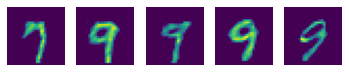

27, 1/100, d=0.120, g=3.533
27, 2/100, d=0.085, g=4.667
27, 3/100, d=0.136, g=3.152
27, 4/100, d=0.164, g=4.164
27, 5/100, d=0.109, g=4.157
27, 6/100, d=0.109, g=3.870
27, 7/100, d=0.139, g=3.789
27, 8/100, d=0.100, g=3.945
27, 9/100, d=0.095, g=3.773
27, 10/100, d=0.090, g=4.097
27, 11/100, d=0.147, g=3.895
27, 12/100, d=0.109, g=4.034
27, 13/100, d=0.105, g=3.742
27, 14/100, d=0.118, g=3.688
27, 15/100, d=0.131, g=3.832
27, 16/100, d=0.121, g=3.689
27, 17/100, d=0.113, g=4.179
27, 18/100, d=0.118, g=4.324
27, 19/100, d=0.119, g=3.360
27, 20/100, d=0.125, g=3.488
27, 21/100, d=0.077, g=4.781
27, 22/100, d=0.079, g=4.084
27, 23/100, d=0.142, g=3.527
27, 24/100, d=0.117, g=5.317
27, 25/100, d=0.147, g=3.345
27, 26/100, d=0.137, g=4.469
27, 27/100, d=0.116, g=3.785
27, 28/100, d=0.081, g=4.592
27, 29/100, d=0.108, g=4.214
27, 30/100, d=0.118, g=3.714
27, 31/100, d=0.100, g=4.539
27, 32/100, d=0.116, g=3.819
27, 33/100, d=0.116, g=4.249
27, 34/100, d=0.131, g=3.501
27, 35/100, d=0.122, g=

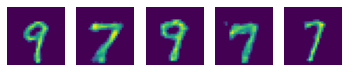

28, 1/100, d=0.142, g=4.333
28, 2/100, d=0.101, g=3.858
28, 3/100, d=0.114, g=3.916
28, 4/100, d=0.122, g=3.649
28, 5/100, d=0.124, g=4.403
28, 6/100, d=0.142, g=3.529
28, 7/100, d=0.125, g=4.254
28, 8/100, d=0.118, g=3.919
28, 9/100, d=0.150, g=3.103
28, 10/100, d=0.107, g=4.690
28, 11/100, d=0.094, g=3.981
28, 12/100, d=0.180, g=4.006
28, 13/100, d=0.116, g=4.040
28, 14/100, d=0.102, g=3.602
28, 15/100, d=0.098, g=4.427
28, 16/100, d=0.112, g=3.570
28, 17/100, d=0.110, g=4.910
28, 18/100, d=0.115, g=4.007
28, 19/100, d=0.144, g=3.902
28, 20/100, d=0.094, g=4.723
28, 21/100, d=0.191, g=3.332
28, 22/100, d=0.115, g=3.404
28, 23/100, d=0.149, g=5.123
28, 24/100, d=0.137, g=3.472
28, 25/100, d=0.147, g=4.288
28, 26/100, d=0.117, g=3.942
28, 27/100, d=0.135, g=4.156
28, 28/100, d=0.114, g=3.989
28, 29/100, d=0.087, g=4.145
28, 30/100, d=0.136, g=4.308
28, 31/100, d=0.092, g=5.004
28, 32/100, d=0.154, g=3.024
28, 33/100, d=0.176, g=4.396
28, 34/100, d=0.122, g=3.610
28, 35/100, d=0.118, g=

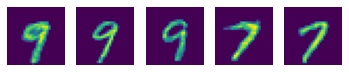

29, 1/100, d=0.134, g=4.293
29, 2/100, d=0.101, g=3.898
29, 3/100, d=0.108, g=3.957
29, 4/100, d=0.115, g=3.760
29, 5/100, d=0.119, g=3.920
29, 6/100, d=0.115, g=4.210
29, 7/100, d=0.136, g=2.850
29, 8/100, d=0.138, g=5.321
29, 9/100, d=0.131, g=4.078
29, 10/100, d=0.117, g=3.714
29, 11/100, d=0.135, g=3.644
29, 12/100, d=0.106, g=4.154
29, 13/100, d=0.122, g=3.894
29, 14/100, d=0.106, g=3.546
29, 15/100, d=0.106, g=4.417
29, 16/100, d=0.112, g=3.823
29, 17/100, d=0.093, g=3.982
29, 18/100, d=0.077, g=4.302
29, 19/100, d=0.106, g=3.926
29, 20/100, d=0.111, g=3.595
29, 21/100, d=0.134, g=3.764
29, 22/100, d=0.111, g=4.245
29, 23/100, d=0.120, g=3.825
29, 24/100, d=0.146, g=3.592
29, 25/100, d=0.098, g=4.676
29, 26/100, d=0.137, g=3.035
29, 27/100, d=0.144, g=4.565
29, 28/100, d=0.147, g=3.564
29, 29/100, d=0.115, g=4.313
29, 30/100, d=0.128, g=4.043
29, 31/100, d=0.093, g=3.985
29, 32/100, d=0.113, g=4.281
29, 33/100, d=0.130, g=2.860
29, 34/100, d=0.143, g=5.234
29, 35/100, d=0.146, g=

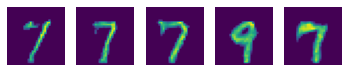

30, 1/100, d=0.115, g=4.003
30, 2/100, d=0.133, g=3.947
30, 3/100, d=0.144, g=4.250
30, 4/100, d=0.124, g=4.221
30, 5/100, d=0.107, g=4.290
30, 6/100, d=0.123, g=3.857
30, 7/100, d=0.102, g=4.277
30, 8/100, d=0.102, g=3.741
30, 9/100, d=0.115, g=4.182
30, 10/100, d=0.113, g=3.595
30, 11/100, d=0.137, g=4.357
30, 12/100, d=0.161, g=4.287
30, 13/100, d=0.104, g=3.692
30, 14/100, d=0.119, g=3.661
30, 15/100, d=0.127, g=3.957
30, 16/100, d=0.146, g=4.081
30, 17/100, d=0.114, g=4.058
30, 18/100, d=0.126, g=3.044
30, 19/100, d=0.158, g=4.877
30, 20/100, d=0.147, g=3.157
30, 21/100, d=0.134, g=4.343
30, 22/100, d=0.116, g=3.621
30, 23/100, d=0.123, g=4.565
30, 24/100, d=0.092, g=3.956
30, 25/100, d=0.114, g=4.342
30, 26/100, d=0.126, g=3.303
30, 27/100, d=0.119, g=4.297
30, 28/100, d=0.140, g=3.746
30, 29/100, d=0.095, g=4.814
30, 30/100, d=0.132, g=4.171
30, 31/100, d=0.155, g=3.399
30, 32/100, d=0.120, g=4.544
30, 33/100, d=0.162, g=2.968
30, 34/100, d=0.155, g=5.038
30, 35/100, d=0.144, g=

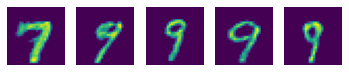

Accuracy real: 94%, fake: 97%
31, 1/100, d=0.108, g=3.727
31, 2/100, d=0.098, g=4.088
31, 3/100, d=0.133, g=3.975
31, 4/100, d=0.120, g=4.414
31, 5/100, d=0.141, g=3.132
31, 6/100, d=0.135, g=4.355
31, 7/100, d=0.195, g=3.077
31, 8/100, d=0.126, g=4.484
31, 9/100, d=0.097, g=4.275
31, 10/100, d=0.120, g=4.019
31, 11/100, d=0.092, g=3.854
31, 12/100, d=0.116, g=3.885
31, 13/100, d=0.098, g=4.293
31, 14/100, d=0.080, g=4.226
31, 15/100, d=0.147, g=3.743
31, 16/100, d=0.113, g=3.375
31, 17/100, d=0.126, g=3.952
31, 18/100, d=0.116, g=3.970
31, 19/100, d=0.111, g=3.797
31, 20/100, d=0.095, g=4.196
31, 21/100, d=0.132, g=3.621
31, 22/100, d=0.129, g=3.909
31, 23/100, d=0.100, g=3.805
31, 24/100, d=0.124, g=3.204
31, 25/100, d=0.133, g=4.070
31, 26/100, d=0.131, g=4.544
31, 27/100, d=0.121, g=3.089
31, 28/100, d=0.136, g=4.420
31, 29/100, d=0.104, g=3.591
31, 30/100, d=0.111, g=3.590
31, 31/100, d=0.098, g=4.278
31, 32/100, d=0.119, g=3.379
31, 33/100, d=0.108, g=4.443
31, 34/100, d=0.108, g

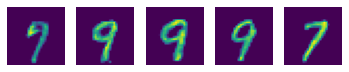

32, 1/100, d=0.114, g=3.598
32, 2/100, d=0.081, g=4.050
32, 3/100, d=0.090, g=3.971
32, 4/100, d=0.086, g=4.127
32, 5/100, d=0.114, g=3.768
32, 6/100, d=0.125, g=3.510
32, 7/100, d=0.096, g=4.396
32, 8/100, d=0.128, g=3.577
32, 9/100, d=0.102, g=4.241
32, 10/100, d=0.123, g=3.825
32, 11/100, d=0.123, g=3.937
32, 12/100, d=0.138, g=3.213
32, 13/100, d=0.105, g=4.101
32, 14/100, d=0.097, g=3.824
32, 15/100, d=0.137, g=3.644
32, 16/100, d=0.107, g=3.322
32, 17/100, d=0.099, g=4.017
32, 18/100, d=0.119, g=4.105
32, 19/100, d=0.133, g=3.740
32, 20/100, d=0.130, g=3.963
32, 21/100, d=0.118, g=3.989
32, 22/100, d=0.093, g=3.541
32, 23/100, d=0.123, g=3.929
32, 24/100, d=0.115, g=4.221
32, 25/100, d=0.132, g=3.096
32, 26/100, d=0.138, g=4.381
32, 27/100, d=0.128, g=3.502
32, 28/100, d=0.104, g=4.077
32, 29/100, d=0.112, g=3.215
32, 30/100, d=0.133, g=4.859
32, 31/100, d=0.136, g=3.570
32, 32/100, d=0.147, g=3.957
32, 33/100, d=0.122, g=3.434
32, 34/100, d=0.118, g=4.595
32, 35/100, d=0.106, g=

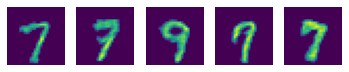

33, 1/100, d=0.113, g=4.074
33, 2/100, d=0.098, g=4.442
33, 3/100, d=0.093, g=3.871
33, 4/100, d=0.106, g=3.860
33, 5/100, d=0.098, g=3.600
33, 6/100, d=0.087, g=4.185
33, 7/100, d=0.105, g=4.670
33, 8/100, d=0.115, g=3.594
33, 9/100, d=0.127, g=3.754
33, 10/100, d=0.088, g=4.420
33, 11/100, d=0.091, g=4.246
33, 12/100, d=0.098, g=3.595
33, 13/100, d=0.104, g=4.302
33, 14/100, d=0.133, g=3.225
33, 15/100, d=0.124, g=5.373
33, 16/100, d=0.139, g=3.805
33, 17/100, d=0.099, g=3.500
33, 18/100, d=0.101, g=4.158
33, 19/100, d=0.083, g=4.527
33, 20/100, d=0.086, g=3.912
33, 21/100, d=0.110, g=3.727
33, 22/100, d=0.097, g=3.996
33, 23/100, d=0.150, g=3.243
33, 24/100, d=0.129, g=4.715
33, 25/100, d=0.128, g=3.744
33, 26/100, d=0.081, g=4.348
33, 27/100, d=0.113, g=3.396
33, 28/100, d=0.139, g=4.936
33, 29/100, d=0.128, g=3.810
33, 30/100, d=0.135, g=3.649
33, 31/100, d=0.111, g=4.007
33, 32/100, d=0.114, g=3.395
33, 33/100, d=0.112, g=4.576
33, 34/100, d=0.106, g=3.545
33, 35/100, d=0.128, g=

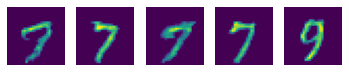

34, 1/100, d=0.128, g=3.306
34, 2/100, d=0.114, g=4.940
34, 3/100, d=0.121, g=4.394
34, 4/100, d=0.129, g=3.177
34, 5/100, d=0.129, g=4.460
34, 6/100, d=0.130, g=3.936
34, 7/100, d=0.111, g=3.704
34, 8/100, d=0.108, g=4.067
34, 9/100, d=0.089, g=3.720
34, 10/100, d=0.117, g=4.165
34, 11/100, d=0.081, g=4.314
34, 12/100, d=0.174, g=3.500
34, 13/100, d=0.104, g=4.225
34, 14/100, d=0.104, g=3.736
34, 15/100, d=0.102, g=4.347
34, 16/100, d=0.123, g=3.390
34, 17/100, d=0.123, g=4.534
34, 18/100, d=0.097, g=4.081
34, 19/100, d=0.089, g=4.350
34, 20/100, d=0.141, g=3.145
34, 21/100, d=0.110, g=5.586
34, 22/100, d=0.128, g=4.292
34, 23/100, d=0.121, g=3.419
34, 24/100, d=0.117, g=3.998
34, 25/100, d=0.130, g=3.812
34, 26/100, d=0.120, g=4.050
34, 27/100, d=0.082, g=4.060
34, 28/100, d=0.131, g=3.471
34, 29/100, d=0.123, g=4.284
34, 30/100, d=0.119, g=3.659
34, 31/100, d=0.133, g=3.875
34, 32/100, d=0.102, g=4.549
34, 33/100, d=0.126, g=3.916
34, 34/100, d=0.106, g=3.108
34, 35/100, d=0.128, g=

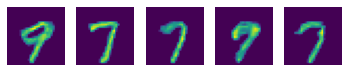

35, 1/100, d=0.139, g=3.189
35, 2/100, d=0.150, g=4.558
35, 3/100, d=0.164, g=2.943
35, 4/100, d=0.127, g=4.426
35, 5/100, d=0.082, g=4.238
35, 6/100, d=0.091, g=4.157
35, 7/100, d=0.137, g=3.334
35, 8/100, d=0.162, g=4.180
35, 9/100, d=0.112, g=3.720
35, 10/100, d=0.087, g=3.990
35, 11/100, d=0.134, g=3.211
35, 12/100, d=0.104, g=3.868
35, 13/100, d=0.122, g=3.672
35, 14/100, d=0.102, g=3.841
35, 15/100, d=0.118, g=3.925
35, 16/100, d=0.089, g=4.308
35, 17/100, d=0.105, g=3.731
35, 18/100, d=0.117, g=3.918
35, 19/100, d=0.079, g=3.976
35, 20/100, d=0.105, g=3.608
35, 21/100, d=0.135, g=3.652
35, 22/100, d=0.097, g=3.992
35, 23/100, d=0.106, g=3.942
35, 24/100, d=0.113, g=4.124
35, 25/100, d=0.102, g=3.559
35, 26/100, d=0.111, g=3.488
35, 27/100, d=0.080, g=3.716
35, 28/100, d=0.102, g=4.588
35, 29/100, d=0.169, g=2.853
35, 30/100, d=0.168, g=5.948
35, 31/100, d=0.152, g=4.702
35, 32/100, d=0.173, g=3.247
35, 33/100, d=0.130, g=3.535
35, 34/100, d=0.096, g=3.988
35, 35/100, d=0.103, g=

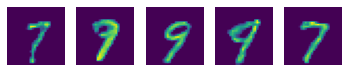

36, 1/100, d=0.108, g=4.222
36, 2/100, d=0.106, g=4.031
36, 3/100, d=0.109, g=3.008
36, 4/100, d=0.161, g=5.265
36, 5/100, d=0.131, g=3.958
36, 6/100, d=0.103, g=3.403
36, 7/100, d=0.126, g=3.532
36, 8/100, d=0.126, g=3.920
36, 9/100, d=0.154, g=3.888
36, 10/100, d=0.113, g=3.503
36, 11/100, d=0.124, g=3.930
36, 12/100, d=0.107, g=3.718
36, 13/100, d=0.111, g=4.054
36, 14/100, d=0.135, g=3.212
36, 15/100, d=0.152, g=4.294
36, 16/100, d=0.128, g=3.081
36, 17/100, d=0.119, g=4.660
36, 18/100, d=0.124, g=3.450
36, 19/100, d=0.121, g=4.051
36, 20/100, d=0.114, g=3.765
36, 21/100, d=0.118, g=3.506
36, 22/100, d=0.093, g=4.288
36, 23/100, d=0.100, g=3.738
36, 24/100, d=0.123, g=3.835
36, 25/100, d=0.129, g=3.444
36, 26/100, d=0.104, g=4.168
36, 27/100, d=0.101, g=3.596
36, 28/100, d=0.115, g=3.952
36, 29/100, d=0.137, g=2.984
36, 30/100, d=0.151, g=5.084
36, 31/100, d=0.183, g=3.287
36, 32/100, d=0.149, g=3.934
36, 33/100, d=0.110, g=3.444
36, 34/100, d=0.159, g=4.068
36, 35/100, d=0.097, g=

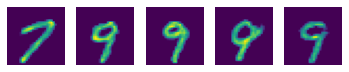

37, 1/100, d=0.097, g=4.251
37, 2/100, d=0.137, g=3.186
37, 3/100, d=0.140, g=4.623
37, 4/100, d=0.085, g=4.041
37, 5/100, d=0.126, g=3.359
37, 6/100, d=0.154, g=4.024
37, 7/100, d=0.110, g=3.868
37, 8/100, d=0.126, g=3.082
37, 9/100, d=0.116, g=4.742
37, 10/100, d=0.138, g=3.236
37, 11/100, d=0.138, g=4.666
37, 12/100, d=0.118, g=4.025
37, 13/100, d=0.114, g=3.016
37, 14/100, d=0.127, g=4.841
37, 15/100, d=0.176, g=3.313
37, 16/100, d=0.108, g=4.115
37, 17/100, d=0.089, g=3.967
37, 18/100, d=0.093, g=4.145
37, 19/100, d=0.107, g=3.608
37, 20/100, d=0.083, g=4.451
37, 21/100, d=0.121, g=3.884
37, 22/100, d=0.126, g=3.539
37, 23/100, d=0.128, g=4.298
37, 24/100, d=0.131, g=3.870
37, 25/100, d=0.091, g=3.974
37, 26/100, d=0.131, g=3.658
37, 27/100, d=0.126, g=4.380
37, 28/100, d=0.083, g=4.231
37, 29/100, d=0.112, g=3.404
37, 30/100, d=0.093, g=4.253
37, 31/100, d=0.087, g=4.064
37, 32/100, d=0.107, g=3.262
37, 33/100, d=0.110, g=4.885
37, 34/100, d=0.099, g=3.778
37, 35/100, d=0.130, g=

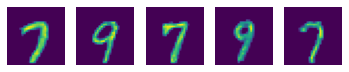

38, 1/100, d=0.117, g=3.728
38, 2/100, d=0.099, g=4.055
38, 3/100, d=0.119, g=3.660
38, 4/100, d=0.108, g=3.894
38, 5/100, d=0.095, g=3.932
38, 6/100, d=0.128, g=3.821
38, 7/100, d=0.118, g=4.090
38, 8/100, d=0.087, g=4.047
38, 9/100, d=0.093, g=4.119
38, 10/100, d=0.139, g=3.795
38, 11/100, d=0.140, g=3.795
38, 12/100, d=0.108, g=3.819
38, 13/100, d=0.116, g=3.973
38, 14/100, d=0.125, g=3.266
38, 15/100, d=0.122, g=4.766
38, 16/100, d=0.090, g=4.127
38, 17/100, d=0.097, g=3.646
38, 18/100, d=0.100, g=3.906
38, 19/100, d=0.123, g=4.328
38, 20/100, d=0.109, g=3.786
38, 21/100, d=0.116, g=3.315
38, 22/100, d=0.110, g=4.671
38, 23/100, d=0.142, g=3.632
38, 24/100, d=0.130, g=3.751
38, 25/100, d=0.135, g=4.373
38, 26/100, d=0.114, g=3.409
38, 27/100, d=0.115, g=3.880
38, 28/100, d=0.103, g=3.727
38, 29/100, d=0.103, g=4.331
38, 30/100, d=0.130, g=3.393
38, 31/100, d=0.098, g=4.172
38, 32/100, d=0.118, g=3.545
38, 33/100, d=0.092, g=4.688
38, 34/100, d=0.133, g=3.370
38, 35/100, d=0.118, g=

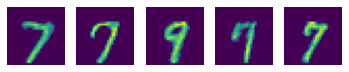

39, 1/100, d=0.130, g=4.121
39, 2/100, d=0.130, g=3.746
39, 3/100, d=0.109, g=3.267
39, 4/100, d=0.114, g=4.083
39, 5/100, d=0.111, g=3.773
39, 6/100, d=0.108, g=4.130
39, 7/100, d=0.114, g=3.948
39, 8/100, d=0.118, g=3.892
39, 9/100, d=0.102, g=3.557
39, 10/100, d=0.148, g=5.012
39, 11/100, d=0.152, g=3.741
39, 12/100, d=0.141, g=3.574
39, 13/100, d=0.112, g=3.801
39, 14/100, d=0.097, g=4.338
39, 15/100, d=0.145, g=3.053
39, 16/100, d=0.113, g=4.888
39, 17/100, d=0.125, g=4.489
39, 18/100, d=0.126, g=3.451
39, 19/100, d=0.087, g=3.918
39, 20/100, d=0.114, g=4.428
39, 21/100, d=0.096, g=4.045
39, 22/100, d=0.104, g=3.413
39, 23/100, d=0.114, g=3.918
39, 24/100, d=0.104, g=3.918
39, 25/100, d=0.147, g=3.519
39, 26/100, d=0.110, g=4.149
39, 27/100, d=0.101, g=3.417
39, 28/100, d=0.128, g=4.256
39, 29/100, d=0.140, g=3.434
39, 30/100, d=0.095, g=4.205
39, 31/100, d=0.105, g=4.253
39, 32/100, d=0.125, g=3.755
39, 33/100, d=0.096, g=4.071
39, 34/100, d=0.124, g=2.933
39, 35/100, d=0.163, g=

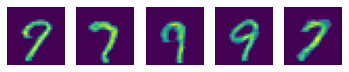

40, 1/100, d=0.099, g=4.129
40, 2/100, d=0.111, g=3.734
40, 3/100, d=0.130, g=4.345
40, 4/100, d=0.112, g=3.576
40, 5/100, d=0.101, g=3.944
40, 6/100, d=0.104, g=4.231
40, 7/100, d=0.123, g=3.417
40, 8/100, d=0.120, g=5.331
40, 9/100, d=0.106, g=4.093
40, 10/100, d=0.086, g=4.318
40, 11/100, d=0.114, g=3.890
40, 12/100, d=0.119, g=3.973
40, 13/100, d=0.112, g=4.081
40, 14/100, d=0.125, g=3.583
40, 15/100, d=0.150, g=4.454
40, 16/100, d=0.091, g=4.598
40, 17/100, d=0.135, g=3.559
40, 18/100, d=0.116, g=4.182
40, 19/100, d=0.117, g=4.339
40, 20/100, d=0.138, g=3.494
40, 21/100, d=0.117, g=4.708
40, 22/100, d=0.116, g=3.644
40, 23/100, d=0.120, g=4.178
40, 24/100, d=0.079, g=4.455
40, 25/100, d=0.109, g=3.366
40, 26/100, d=0.130, g=4.618
40, 27/100, d=0.099, g=4.342
40, 28/100, d=0.111, g=3.534
40, 29/100, d=0.096, g=4.057
40, 30/100, d=0.086, g=4.181
40, 31/100, d=0.108, g=3.486
40, 32/100, d=0.108, g=3.785
40, 33/100, d=0.102, g=3.971
40, 34/100, d=0.111, g=3.819
40, 35/100, d=0.094, g=

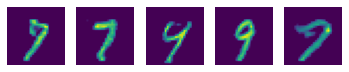

Accuracy real: 88%, fake: 100%
41, 1/100, d=0.115, g=3.780
41, 2/100, d=0.107, g=3.655
41, 3/100, d=0.107, g=4.223
41, 4/100, d=0.090, g=4.251
41, 5/100, d=0.161, g=2.828
41, 6/100, d=0.161, g=5.117
41, 7/100, d=0.121, g=4.327
41, 8/100, d=0.163, g=2.944
41, 9/100, d=0.129, g=4.236
41, 10/100, d=0.096, g=4.387
41, 11/100, d=0.119, g=3.304
41, 12/100, d=0.119, g=4.234
41, 13/100, d=0.103, g=3.799
41, 14/100, d=0.113, g=3.995
41, 15/100, d=0.106, g=3.646
41, 16/100, d=0.128, g=3.432
41, 17/100, d=0.122, g=4.007
41, 18/100, d=0.108, g=3.795
41, 19/100, d=0.106, g=4.397
41, 20/100, d=0.159, g=3.553
41, 21/100, d=0.132, g=3.639
41, 22/100, d=0.118, g=3.752
41, 23/100, d=0.080, g=4.036
41, 24/100, d=0.091, g=4.018
41, 25/100, d=0.108, g=3.800
41, 26/100, d=0.101, g=4.259
41, 27/100, d=0.116, g=3.382
41, 28/100, d=0.157, g=3.690
41, 29/100, d=0.117, g=3.947
41, 30/100, d=0.105, g=3.814
41, 31/100, d=0.077, g=3.871
41, 32/100, d=0.141, g=3.835
41, 33/100, d=0.119, g=3.431
41, 34/100, d=0.139, 

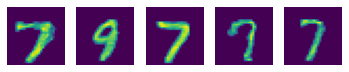

42, 1/100, d=0.083, g=3.823
42, 2/100, d=0.080, g=4.390
42, 3/100, d=0.134, g=3.630
42, 4/100, d=0.149, g=3.808
42, 5/100, d=0.129, g=3.948
42, 6/100, d=0.094, g=3.963
42, 7/100, d=0.088, g=4.218
42, 8/100, d=0.146, g=3.641
42, 9/100, d=0.117, g=3.954
42, 10/100, d=0.146, g=3.328
42, 11/100, d=0.143, g=4.950
42, 12/100, d=0.129, g=3.596
42, 13/100, d=0.120, g=4.491
42, 14/100, d=0.154, g=3.177
42, 15/100, d=0.098, g=3.888
42, 16/100, d=0.116, g=3.701
42, 17/100, d=0.150, g=3.389
42, 18/100, d=0.129, g=4.019
42, 19/100, d=0.125, g=3.915
42, 20/100, d=0.150, g=3.419
42, 21/100, d=0.112, g=4.584
42, 22/100, d=0.121, g=3.726
42, 23/100, d=0.131, g=3.801
42, 24/100, d=0.143, g=3.273
42, 25/100, d=0.117, g=4.514
42, 26/100, d=0.121, g=4.208
42, 27/100, d=0.095, g=3.975
42, 28/100, d=0.130, g=3.599
42, 29/100, d=0.101, g=4.138
42, 30/100, d=0.066, g=4.391
42, 31/100, d=0.098, g=4.302
42, 32/100, d=0.103, g=3.816
42, 33/100, d=0.104, g=3.731
42, 34/100, d=0.166, g=4.222
42, 35/100, d=0.107, g=

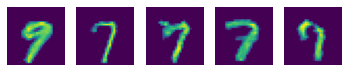

43, 1/100, d=0.096, g=4.727
43, 2/100, d=0.136, g=4.039
43, 3/100, d=0.127, g=2.955
43, 4/100, d=0.118, g=4.911
43, 5/100, d=0.096, g=4.292
43, 6/100, d=0.116, g=3.753
43, 7/100, d=0.108, g=3.560
43, 8/100, d=0.123, g=4.462
43, 9/100, d=0.096, g=3.571
43, 10/100, d=0.082, g=3.718
43, 11/100, d=0.111, g=3.937
43, 12/100, d=0.124, g=3.900
43, 13/100, d=0.128, g=3.724
43, 14/100, d=0.088, g=4.233
43, 15/100, d=0.089, g=4.162
43, 16/100, d=0.092, g=3.906
43, 17/100, d=0.105, g=3.832
43, 18/100, d=0.112, g=3.561
43, 19/100, d=0.122, g=4.617
43, 20/100, d=0.105, g=3.409
43, 21/100, d=0.119, g=4.051
43, 22/100, d=0.082, g=4.446
43, 23/100, d=0.127, g=3.586
43, 24/100, d=0.116, g=3.505
43, 25/100, d=0.113, g=4.198
43, 26/100, d=0.132, g=3.733
43, 27/100, d=0.125, g=4.069
43, 28/100, d=0.088, g=4.379
43, 29/100, d=0.096, g=3.854
43, 30/100, d=0.083, g=3.672
43, 31/100, d=0.130, g=4.093
43, 32/100, d=0.088, g=3.785
43, 33/100, d=0.091, g=3.697
43, 34/100, d=0.108, g=3.871
43, 35/100, d=0.116, g=

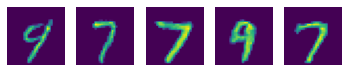

44, 1/100, d=0.146, g=4.529
44, 2/100, d=0.143, g=3.490
44, 3/100, d=0.117, g=3.871
44, 4/100, d=0.106, g=4.116
44, 5/100, d=0.144, g=3.413
44, 6/100, d=0.125, g=3.380
44, 7/100, d=0.094, g=3.829
44, 8/100, d=0.125, g=4.060
44, 9/100, d=0.147, g=3.195
44, 10/100, d=0.126, g=4.220
44, 11/100, d=0.100, g=3.832
44, 12/100, d=0.107, g=3.404
44, 13/100, d=0.119, g=4.091
44, 14/100, d=0.087, g=3.695
44, 15/100, d=0.096, g=4.222
44, 16/100, d=0.102, g=4.019
44, 17/100, d=0.095, g=4.165
44, 18/100, d=0.135, g=3.239
44, 19/100, d=0.149, g=3.947
44, 20/100, d=0.117, g=4.279
44, 21/100, d=0.094, g=3.645
44, 22/100, d=0.117, g=3.449
44, 23/100, d=0.102, g=4.653
44, 24/100, d=0.106, g=4.004
44, 25/100, d=0.105, g=3.668
44, 26/100, d=0.122, g=4.769
44, 27/100, d=0.110, g=4.015
44, 28/100, d=0.101, g=3.660
44, 29/100, d=0.143, g=3.634
44, 30/100, d=0.105, g=4.108
44, 31/100, d=0.120, g=3.896
44, 32/100, d=0.102, g=3.998
44, 33/100, d=0.109, g=3.376
44, 34/100, d=0.129, g=3.842
44, 35/100, d=0.102, g=

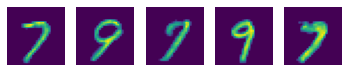

45, 1/100, d=0.099, g=3.849
45, 2/100, d=0.124, g=3.372
45, 3/100, d=0.110, g=3.899
45, 4/100, d=0.152, g=3.279
45, 5/100, d=0.091, g=4.383
45, 6/100, d=0.108, g=3.420
45, 7/100, d=0.093, g=3.993
45, 8/100, d=0.106, g=4.046
45, 9/100, d=0.119, g=3.339
45, 10/100, d=0.117, g=5.139
45, 11/100, d=0.108, g=3.963
45, 12/100, d=0.106, g=4.078
45, 13/100, d=0.126, g=3.769
45, 14/100, d=0.107, g=3.319
45, 15/100, d=0.107, g=4.164
45, 16/100, d=0.110, g=4.028
45, 17/100, d=0.099, g=3.699
45, 18/100, d=0.107, g=3.738
45, 19/100, d=0.142, g=3.246
45, 20/100, d=0.110, g=4.205
45, 21/100, d=0.143, g=3.278
45, 22/100, d=0.108, g=4.748
45, 23/100, d=0.142, g=3.480
45, 24/100, d=0.100, g=4.326
45, 25/100, d=0.101, g=3.813
45, 26/100, d=0.103, g=3.621
45, 27/100, d=0.091, g=3.963
45, 28/100, d=0.107, g=3.775
45, 29/100, d=0.114, g=3.709
45, 30/100, d=0.104, g=4.832
45, 31/100, d=0.151, g=3.612
45, 32/100, d=0.101, g=3.508
45, 33/100, d=0.104, g=3.959
45, 34/100, d=0.081, g=4.515
45, 35/100, d=0.109, g=

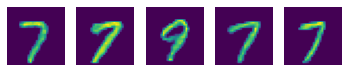

46, 1/100, d=0.110, g=3.792
46, 2/100, d=0.118, g=4.034
46, 3/100, d=0.111, g=4.010
46, 4/100, d=0.076, g=3.995
46, 5/100, d=0.110, g=3.585
46, 6/100, d=0.112, g=4.514
46, 7/100, d=0.096, g=4.436
46, 8/100, d=0.129, g=3.274
46, 9/100, d=0.114, g=4.775
46, 10/100, d=0.124, g=3.810
46, 11/100, d=0.084, g=4.424
46, 12/100, d=0.111, g=3.837
46, 13/100, d=0.089, g=4.127
46, 14/100, d=0.106, g=3.832
46, 15/100, d=0.094, g=5.062
46, 16/100, d=0.109, g=3.743
46, 17/100, d=0.073, g=4.025
46, 18/100, d=0.119, g=3.784
46, 19/100, d=0.093, g=4.438
46, 20/100, d=0.134, g=3.923
46, 21/100, d=0.101, g=4.023
46, 22/100, d=0.123, g=4.362
46, 23/100, d=0.105, g=3.636
46, 24/100, d=0.111, g=3.635
46, 25/100, d=0.094, g=4.503
46, 26/100, d=0.127, g=3.317
46, 27/100, d=0.110, g=4.552
46, 28/100, d=0.122, g=3.764
46, 29/100, d=0.104, g=3.841
46, 30/100, d=0.099, g=3.807
46, 31/100, d=0.134, g=3.146
46, 32/100, d=0.126, g=4.823
46, 33/100, d=0.152, g=3.329
46, 34/100, d=0.129, g=4.645
46, 35/100, d=0.112, g=

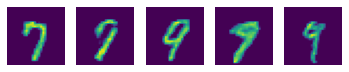

47, 1/100, d=0.093, g=3.606
47, 2/100, d=0.110, g=4.281
47, 3/100, d=0.126, g=3.555
47, 4/100, d=0.086, g=4.417
47, 5/100, d=0.111, g=3.705
47, 6/100, d=0.107, g=3.709
47, 7/100, d=0.114, g=3.820
47, 8/100, d=0.089, g=3.618
47, 9/100, d=0.105, g=4.318
47, 10/100, d=0.123, g=3.581
47, 11/100, d=0.121, g=4.432
47, 12/100, d=0.118, g=4.124
47, 13/100, d=0.090, g=4.389
47, 14/100, d=0.125, g=3.074
47, 15/100, d=0.140, g=4.359
47, 16/100, d=0.095, g=4.416
47, 17/100, d=0.114, g=3.204
47, 18/100, d=0.134, g=5.730
47, 19/100, d=0.099, g=4.806
47, 20/100, d=0.122, g=3.649
47, 21/100, d=0.113, g=3.872
47, 22/100, d=0.105, g=3.462
47, 23/100, d=0.127, g=3.998
47, 24/100, d=0.114, g=3.756
47, 25/100, d=0.120, g=3.912
47, 26/100, d=0.137, g=4.252
47, 27/100, d=0.097, g=4.311
47, 28/100, d=0.071, g=4.024
47, 29/100, d=0.127, g=3.830
47, 30/100, d=0.133, g=3.575
47, 31/100, d=0.109, g=4.190
47, 32/100, d=0.106, g=3.892
47, 33/100, d=0.071, g=4.152
47, 34/100, d=0.093, g=3.854
47, 35/100, d=0.087, g=

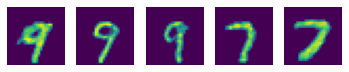

48, 1/100, d=0.141, g=4.037
48, 2/100, d=0.125, g=3.932
48, 3/100, d=0.123, g=4.292
48, 4/100, d=0.156, g=3.214
48, 5/100, d=0.095, g=4.167
48, 6/100, d=0.098, g=4.036
48, 7/100, d=0.125, g=3.656
48, 8/100, d=0.126, g=4.110
48, 9/100, d=0.101, g=3.862
48, 10/100, d=0.132, g=3.534
48, 11/100, d=0.124, g=4.285
48, 12/100, d=0.103, g=3.793
48, 13/100, d=0.146, g=3.465
48, 14/100, d=0.105, g=3.649
48, 15/100, d=0.110, g=4.393
48, 16/100, d=0.126, g=4.028
48, 17/100, d=0.122, g=4.667
48, 18/100, d=0.100, g=4.193
48, 19/100, d=0.120, g=3.459
48, 20/100, d=0.097, g=3.695
48, 21/100, d=0.120, g=4.028
48, 22/100, d=0.089, g=3.811
48, 23/100, d=0.101, g=3.198
48, 24/100, d=0.117, g=4.476
48, 25/100, d=0.145, g=2.883
48, 26/100, d=0.167, g=5.055
48, 27/100, d=0.110, g=3.965
48, 28/100, d=0.104, g=4.345
48, 29/100, d=0.121, g=3.462
48, 30/100, d=0.122, g=3.860
48, 31/100, d=0.096, g=4.427
48, 32/100, d=0.129, g=3.944
48, 33/100, d=0.145, g=2.983
48, 34/100, d=0.154, g=5.052
48, 35/100, d=0.134, g=

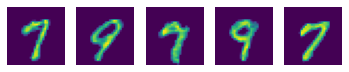

49, 1/100, d=0.092, g=3.679
49, 2/100, d=0.121, g=3.600
49, 3/100, d=0.087, g=4.153
49, 4/100, d=0.110, g=3.548
49, 5/100, d=0.105, g=3.456
49, 6/100, d=0.105, g=4.000
49, 7/100, d=0.123, g=3.409
49, 8/100, d=0.118, g=3.957
49, 9/100, d=0.107, g=3.959
49, 10/100, d=0.105, g=3.734
49, 11/100, d=0.091, g=4.394
49, 12/100, d=0.088, g=4.482
49, 13/100, d=0.109, g=3.729
49, 14/100, d=0.114, g=3.845
49, 15/100, d=0.107, g=4.216
49, 16/100, d=0.110, g=3.644
49, 17/100, d=0.110, g=4.506
49, 18/100, d=0.115, g=3.723
49, 19/100, d=0.098, g=4.288
49, 20/100, d=0.115, g=3.757
49, 21/100, d=0.103, g=3.981
49, 22/100, d=0.126, g=3.993
49, 23/100, d=0.115, g=4.049
49, 24/100, d=0.121, g=3.879
49, 25/100, d=0.125, g=3.928
49, 26/100, d=0.082, g=3.867
49, 27/100, d=0.111, g=3.938
49, 28/100, d=0.120, g=3.766
49, 29/100, d=0.088, g=4.577
49, 30/100, d=0.140, g=3.211
49, 31/100, d=0.113, g=4.355
49, 32/100, d=0.106, g=4.204
49, 33/100, d=0.077, g=3.842
49, 34/100, d=0.115, g=3.835
49, 35/100, d=0.106, g=

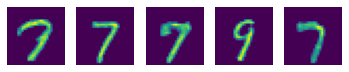

50, 1/100, d=0.111, g=4.756
50, 2/100, d=0.139, g=3.484
50, 3/100, d=0.110, g=4.627
50, 4/100, d=0.088, g=4.247
50, 5/100, d=0.099, g=3.849
50, 6/100, d=0.124, g=3.954
50, 7/100, d=0.121, g=3.502
50, 8/100, d=0.108, g=4.232
50, 9/100, d=0.115, g=4.313
50, 10/100, d=0.103, g=3.762
50, 11/100, d=0.129, g=3.926
50, 12/100, d=0.119, g=3.203
50, 13/100, d=0.111, g=4.409
50, 14/100, d=0.130, g=3.103
50, 15/100, d=0.139, g=5.267
50, 16/100, d=0.123, g=4.075
50, 17/100, d=0.105, g=4.039
50, 18/100, d=0.117, g=3.959
50, 19/100, d=0.104, g=4.095
50, 20/100, d=0.102, g=4.559
50, 21/100, d=0.102, g=4.082
50, 22/100, d=0.103, g=3.724
50, 23/100, d=0.117, g=4.377
50, 24/100, d=0.090, g=3.970
50, 25/100, d=0.113, g=3.382
50, 26/100, d=0.118, g=3.930
50, 27/100, d=0.100, g=3.831
50, 28/100, d=0.095, g=3.726
50, 29/100, d=0.124, g=4.045
50, 30/100, d=0.097, g=3.824
50, 31/100, d=0.100, g=3.786
50, 32/100, d=0.102, g=4.391
50, 33/100, d=0.091, g=4.473
50, 34/100, d=0.158, g=3.273
50, 35/100, d=0.134, g=

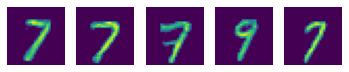

Accuracy real: 95%, fake: 96%


In [ ]:
train_GAN(model_G, model_D, model_GAN, dataset, latent_dim)